# Benchmarking scripts for Tangram

## Intallation of the running environment

* Install the envrioment of Tangram based on the instructions: https://github.com/broadinstitute/Tangram

In [2]:
import tangram as tg
import scanpy as sc
import anndata
import os
import logging
import numpy as np
from scipy.spatial.distance import cdist
import utils
import importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
importlib.reload(utils)
logging.getLogger().setLevel(logging.INFO)

/home/smli/miniconda2/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilized functions

In [3]:
def getPredictedCoor(train_data,test_data,mapping_mat):
    
    
    train_coor = np.column_stack((train_data.obs['x'].values,train_data.obs['y'].values))
    predicted_coor = []
    for i in range(mapping_mat.shape[0]):
        cur_mapping_probs = mapping_mat[i]
        
        cur_ind = np.argmax(cur_mapping_probs)
        cur_predicted_coor = np.take(train_coor,cur_ind,axis=0)
        
        predicted_coor.append(cur_predicted_coor)
    
    predicted_coor = np.asarray(predicted_coor)
    
    return predicted_coor

## 1. Spatial reconstruction of mouse gastrulation cells using single-cell resolution ST reference 

### 1.1 Load data

In [3]:
# Please modify the data path as neccessary 

DATA_ROOT = "../benchmarking_data"

embryo1_l1 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))

print(embryo1_l1.shape,embryo1_l2.shape,embryo2_l2.shape,embryo3_l2.shape)

(10150, 351) (7656, 351) (6524, 351) (9408, 351)


### 1.2 Performing alignment and evaluation

In [4]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}
# set the reference data
ad_sp = embryo1_l1

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
    logging.info("Aligning data for "+test_name)
    ad_sc = cur_test_adata
    tg.pp_adatas(ad_sc, ad_sp, genes=None)
    ad_map = tg.map_cells_to_space(ad_sc, ad_sp)
    logging.info("Aligning DONE")
    mapping_mat = ad_map.X
    
    predicted_coor = getPredictedCoor(ad_sp,ad_sc,mapping_mat)
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for embryo1_l2
INFO:root:351 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:351 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 351 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.486, KL reg: 0.014
Score: 0.721, KL reg: 0.001
Score: 0.735, KL reg: 0.001
Score: 0.738, KL reg: 0.001
Score: 0.740, KL reg: 0.001
Score: 0.741, KL reg: 0.001
Score: 0.741, KL reg: 0.001
Score: 0.742, KL reg: 0.001
Score: 0.742, KL reg: 0.001
Score: 0.742, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:21<00:00, 356.44it/s]
INFO:root:Aligning data for embryo2_l2
INFO:root:351 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:351 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 351 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.486, KL reg: 0.014
Score: 0.713, KL reg: 0.001
Score: 0.727, KL reg: 0.001
Score: 0.730, KL reg: 0.001
Score: 0.731, KL reg: 0.001
Score: 0.732, KL reg: 0.001
Score: 0.733, KL reg: 0.001
Score: 0.733, KL reg: 0.001
Score: 0.734, KL reg: 0.001
Score: 0.734, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6524/6524 [00:16<00:00, 403.88it/s]
INFO:root:Aligning data for embryo3_l2
INFO:root:351 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:351 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 351 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.486, KL reg: 0.014
Score: 0.732, KL reg: 0.001
Score: 0.748, KL reg: 0.001
Score: 0.752, KL reg: 0.001
Score: 0.753, KL reg: 0.001
Score: 0.754, KL reg: 0.001
Score: 0.755, KL reg: 0.001
Score: 0.755, KL reg: 0.001
Score: 0.756, KL reg: 0.001
Score: 0.756, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9408/9408 [00:29<00:00, 316.21it/s]


In [5]:
res_summary_all.to_csv("results/tangram_mouse_single_cell_ref.csv")

### 1.3 Benchmarking results

#### 1.3.1 Nearest neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

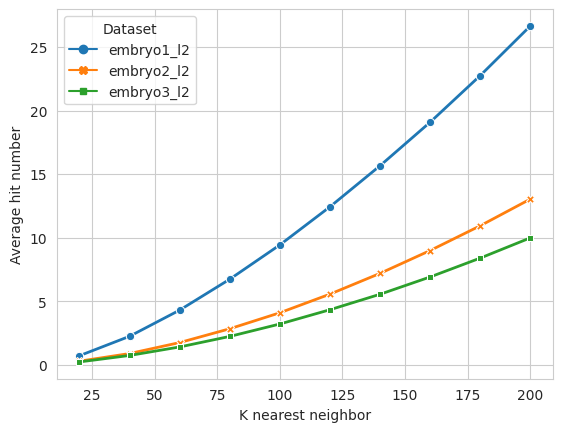

In [6]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 1.3.2 Average JSD and  spearman's rank correlation coefficient


In [7]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.526323,0.296259
1,embryo2_l2,0.540290,0.073249
2,embryo3_l2,0.613265,0.095110


## 2. Spatial location inference across platforms: mouse gastrulation datasets

### 2.1 Load data

In [8]:
# Please modify the data path as needed
DATA_ROOT = "../benchmarking_data"
stereoseq_E2S1 = sc.read_h5ad(os.path.join(DATA_ROOT,"stereoseq_E2S1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))


### 2.2 Performing alignment and evaluation

In [13]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}
# set the reference data
ad_sp = stereoseq_E2S1

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
    logging.info("Aligning data for "+test_name)
    ad_sc = cur_test_adata
    tg.pp_adatas(ad_sc, ad_sp, genes=None)
    ad_map = tg.map_cells_to_space(ad_sc, ad_sp)
    logging.info("Aligning DONE")
    mapping_mat = ad_map.X
    predicted_coor = getPredictedCoor(ad_sp,ad_sc,mapping_mat)
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)
    
neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for embryo1_l2
INFO:root:349 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:349 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 349 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.301, KL reg: 0.023
Score: 0.594, KL reg: 0.006
Score: 0.606, KL reg: 0.005
Score: 0.608, KL reg: 0.005
Score: 0.609, KL reg: 0.005
Score: 0.609, KL reg: 0.005
Score: 0.610, KL reg: 0.005
Score: 0.610, KL reg: 0.005
Score: 0.610, KL reg: 0.005
Score: 0.611, KL reg: 0.005


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:19<00:00, 391.40it/s]
INFO:root:Aligning data for embryo2_l2
INFO:root:349 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:349 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 349 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.301, KL reg: 0.023
Score: 0.606, KL reg: 0.006
Score: 0.617, KL reg: 0.005
Score: 0.619, KL reg: 0.005
Score: 0.620, KL reg: 0.005
Score: 0.620, KL reg: 0.005
Score: 0.621, KL reg: 0.005
Score: 0.621, KL reg: 0.005
Score: 0.621, KL reg: 0.005
Score: 0.621, KL reg: 0.005


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6524/6524 [00:14<00:00, 439.28it/s]
INFO:root:Aligning data for embryo3_l2
INFO:root:349 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:349 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 349 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.301, KL reg: 0.023
Score: 0.635, KL reg: 0.006
Score: 0.647, KL reg: 0.005
Score: 0.650, KL reg: 0.005
Score: 0.651, KL reg: 0.005
Score: 0.652, KL reg: 0.005
Score: 0.652, KL reg: 0.005
Score: 0.652, KL reg: 0.005
Score: 0.653, KL reg: 0.005
Score: 0.653, KL reg: 0.005


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9408/9408 [00:26<00:00, 349.03it/s]


In [14]:
res_summary_all.to_csv("results/tangram_mouse_stereoseq_ref.csv")

### 2.3 Benchmarking results

#### 2.3.1 Nearest neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

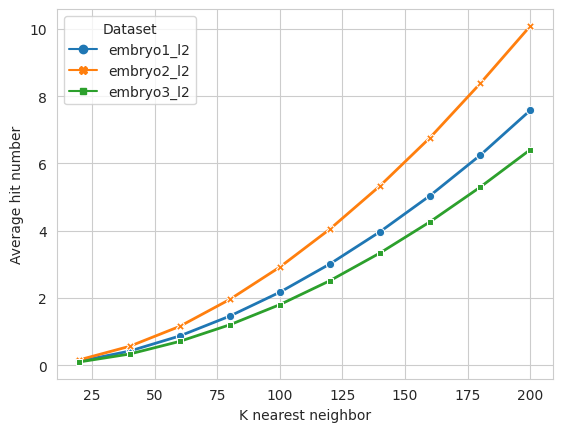

In [17]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 2.3.2 Average JSD and  spearman's rank correlation coefficient


In [18]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.627456,0.038806
1,embryo2_l2,0.573128,0.075179
2,embryo3_l2,0.640634,0.047662


## 3. Spatial location inference across platforms: human breast cancer datasets


### 3.1 Load data

In [22]:
DATA_ROOT = "../benchmarking_data"
human_breast_s06 = sc.read_h5ad(os.path.join(DATA_ROOT,"s06_normal.h5ad"))
human_breast_s08 = sc.read_h5ad(os.path.join(DATA_ROOT,"s08_normal.h5ad"))
print("human_breast_s06",human_breast_s06.shape,"human_breast_s08",human_breast_s08.shape)

human_breast_s06 (3037, 36503) human_breast_s08 (2801, 36503)


### 3.2 Performing alignment and evaluation

In [23]:
# set the reference data
ad_sp = human_breast_s06
# set the query data
ad_sc = human_breast_s08
neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}


cur_test_adata = human_breast_s08
cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
logging.info("Aligning data for "+"Human breast cells")
ad_sc = cur_test_adata
tg.pp_adatas(ad_sc, ad_sp, genes=None)
ad_map = tg.map_cells_to_space(ad_sc, ad_sp)
logging.info("Aligning DONE")
mapping_mat = ad_map.X
predicted_coor = getPredictedCoor(ad_sp,ad_sc,mapping_mat)
predicted_distances =  cdist(predicted_coor, predicted_coor)
predicted_sorted_ind = np.argsort(predicted_distances)
    
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)
    
# neighbor hit
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend(["human breast S08"]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
# JSD
cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
# Spearman rank correlation
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
JSD_spearman_res['Dataset'].append("human breast S08")
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
res_summary_all['Dataset'].extend(["human breast S08"]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)
    
neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for Human breast cells
INFO:root:18314 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18314 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 18314 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.199, KL reg: 0.034
Score: 0.350, KL reg: 0.000
Score: 0.355, KL reg: 0.000
Score: 0.356, KL reg: 0.000
Score: 0.356, KL reg: 0.000
Score: 0.357, KL reg: 0.000
Score: 0.357, KL reg: 0.000
Score: 0.357, KL reg: 0.000
Score: 0.357, KL reg: 0.000
Score: 0.357, KL reg: 0.000


INFO:root:Saving results..
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2801/2801 [00:04<00:00, 637.78it/s]


In [24]:
res_summary_all.to_csv("results/tangram_human_breast.csv")

### 3.3 Benchmarking results

#### 3.3.1 Nearest neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

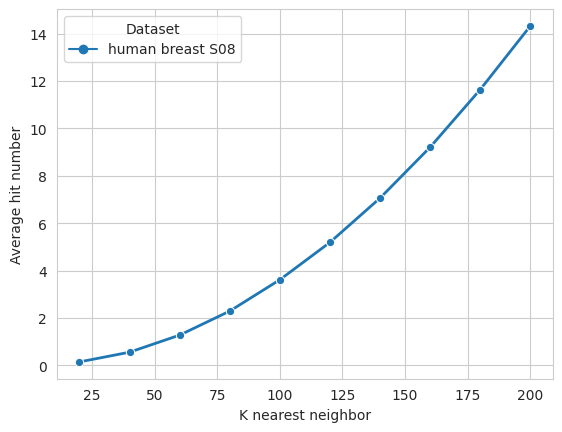

In [25]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 2.3.2 Average JSD and  spearman's rank correlation coefficient


In [26]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,human breast S08,0.485774,0.008958


## 4. Spatial location inference: mouse brain cells generated by MERSCOPE

### 4.1. Load data

In [9]:
DATA_ROOT = "../benchmarking_data"
left_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_left_original.h5ad"))
right_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_right_original.h5ad"))

### 4.2 Performing alignment and evaluation

In [ ]:
# set the reference data
ad_sp = left_brain_adata
# set the query data
ad_sc = right_brain_adata

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}


cur_test_adata = ad_sc
cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
logging.info("Aligning data for "+"merfish")
ad_sc = cur_test_adata
tg.pp_adatas(ad_sc, ad_sp, genes=None)
ad_map = tg.map_cells_to_space(ad_sc, ad_sp)
logging.info("Aligning DONE")
mapping_mat = ad_map.X
predicted_coor = getPredictedCoor(ad_sp,ad_sc,mapping_mat)
predicted_distances =  cdist(predicted_coor, predicted_coor)
predicted_sorted_ind = np.argsort(predicted_distances)
    
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)
    
# neighbor hit
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend(["human breast S08"]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
# JSD
cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
# Spearman rank correlation
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
JSD_spearman_res['Dataset'].append("human breast S08")
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
res_summary_all['Dataset'].extend(["human breast S08"]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)
    
neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for merfish
INFO:root:649 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:649 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 649 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.309, KL reg: 0.003
Score: 0.809, KL reg: 0.001
Score: 0.823, KL reg: 0.001
Score: 0.826, KL reg: 0.001
Score: 0.828, KL reg: 0.001
Score: 0.829, KL reg: 0.001
Score: 0.829, KL reg: 0.001
Score: 0.830, KL reg: 0.001
Score: 0.830, KL reg: 0.001
Score: 0.830, KL reg: 0.001


INFO:root:Saving results..
INFO:root:Aligning DONE
 70%|████████████████████████████████████████████████▎                    | 6591/9419 [00:21<00:08, 315.12it/s]

### 4.4 Benchmarking results

#### 4.4.1 Nearest neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

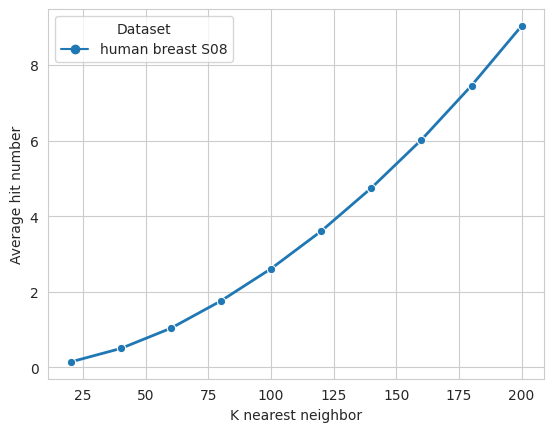

In [15]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 4.4.2 Average spearman's rank correlation coefficient

In [16]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,human breast S08,NaN,0.136098
